<a href="https://colab.research.google.com/github/TtaHk7211/HUHackathon2022Team05/blob/master/Pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

・テンソル

numpyのndarraysと違い, GPUやほかのハードウェア上で動作可能

モデルの訓練に用いる自動微分に最適化されている

In [ ]:
%matplotlib inline

import torch
import numpy as np


## テンソルの初期化
# 数値から変換 (torch.tensor())
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

# NumPy arrayから変換 (torch.from_numpy())
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# 他のテンソルから作成
x_ones = torch.ones_like(x_data)  # x_dataと同じ形で全要素1のテンソル
x_rand = torch.rand_like(x_data, dtype=torch.float)  # x_dataのdatatypeを上書きして乱数生成

# 大きさを与えてランダム値や定数のテンソル作成
shape = (2, 3, )
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)


## テンソルの属性
# tensor.shape (次元), tensor.dtype (要素の型), tensor.device (cpu, gpuなど, どのデバイスに割り当てるか)

In [ ]:
### テンソルの操作
## GPUへの移動
tensor = torch.rand(3, 4)
if torch.cuda.is_available():
  tensor = tensor.to('cuda')

## 値の取り出し・代入
tensor = torch.ones(4, 4)

print(tensor[0])  # 1行目
print(tensor[:,0])  # 1列目
print(tensor[..., -1])  # 最終列
tensor[:, 1]=0  # 1列全てに値を代入
print(tensor)

## テンソルの結合
t1 = torch.cat([tensor, tensor, tensor], dim=1)  # 横に結合 (dim=0なら縦に結合)
print(t1)

## 演算
# 行列の掛け算 (@, matmul)
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)
# y3 = torch.rand_like(tensor)
# torch.matmul(tensor, tensor.T, out=y3)

# 要素ごとの積 (*, mul)
z1 = tensor * tensor
z2 = tensor.mul(tensor)
# z3 = torch.rand_like(tensor)
# torch.mul(tensor, tensor, out=z3)

# 1要素のテンソル
agg = tensor.sum()  # 全要素合計を出すと1要素のテンソルになる
agg_item = agg.item()  # .item()によてテンソル → 数値

# 演算結果をそのまま変数に代入したいとき (インプレース操作, 使わない)
tensor.add_(5)  # 操作名の後に_がつく

tensor([1., 1., 1., 1.])
tensor([1., 1., 1., 1.])
tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])

In [ ]:
## テンソルとnumpyの変換
tensor = torch.ones(5)
n = tensor.numpy()

# ここで一方の値の変更はもう片方にも反映される

・データセットの扱い

モデルの訓練コードから切り離して扱うとよい。

Dataset (torch.utils.data.Dataset) はサンプルとそれに対応するラベルが格納されている。

DataLoader (torch.utils.data.DataLoader) にはイテレート処理が可能なデータが格納されており, Datasetをイテレート処理可能なものへラップする。

DataLoaderではモデルのミニバッチ分割や, 複数データの取り出しの高速化をしてくれるAPI。

In [ ]:
## Datasetの読み込み (FashionMNISTを読み込む)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

# root(訓練/テストデータへのパス), train(訓練データかテストデータか),
# download=True(rootにデータが存在しない場合にインターネットからダウンロードするか), transform(特徴量とラベルの変換を指定)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

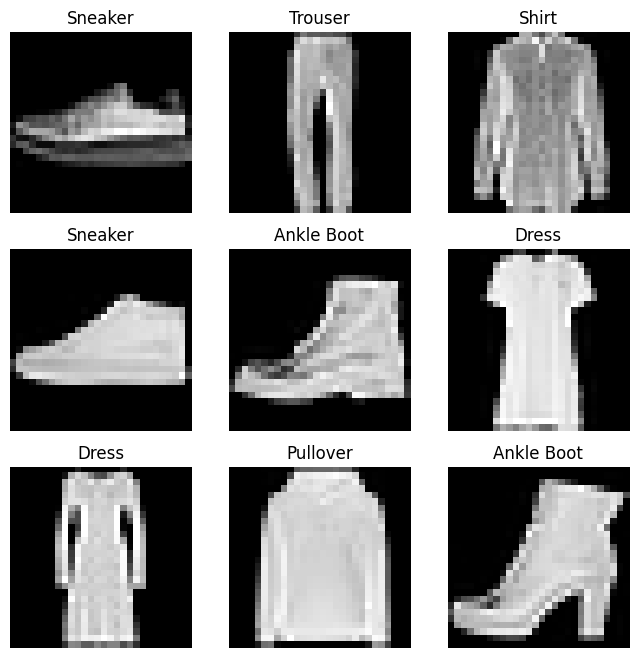

In [ ]:
## データセットの可視化と反復処理
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))  # 台紙の作成
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()  # ランダムに画像を選ぶ
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")  # サイズが1の次元を削除 (画像テンソルにはありがち)
plt.show()

In [ ]:
## 自分でDatasetクラスを作成 (__init__, __len__, __getitem__が必要)
import os
import pandas as pd
from torchvision.io import read_image

# Datasetクラスを継承したCustomImageDatasetクラスを作成
class CustomImageDataset(Dataset):
  # データセットの初期化
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)  # ラベルデータのCSVファイルを読み込み
    self.img_dir = img_dir  # 画像データがあるディレクトリのパスを読み込み
    self.transform = transform  # 画像データに対する変換
    self.target_transform = target_transform  # ラベルデータに対する変換

  # データセットのサンプル数を返す
  def __len__(self):
    return len(self.img_labels)

  # 指定されたインデックスに対応するサンプルを返す
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)  # 画像ファイルをテンソルに変換
    label = self.img_labels.iloc[idx, 1]  # ラベルを抽出
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    sample = {"image": image, "label": label}  # 画像とラベルの辞書を作成
    return sample

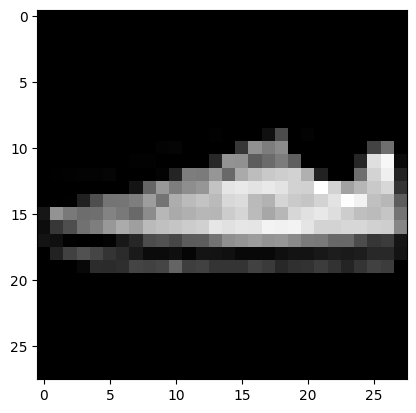

Label: 7


In [ ]:
## DataLoaderの使用
from torch.utils.data import DataLoader

# データセットを読み込む
# 以降の反復処理ではミニバッチを返し, データの順番はシャッフルされる
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_detaloader = DataLoader(test_data, batch_size=64, shuffle=True)

# 画像とラベルの可視化
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

・データセットの処理 (正規化など)

Transformを利用して学習に適した形へ変換する。

torchvision.transformsモジュールが有用。

In [ ]:
!pip install torchvision
from torchvision import detasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(x), value=1))
)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

ImportError: cannot import name 'detasets' from 'torchvision' (/usr/local/lib/python3.10/dist-packages/torchvision/__init__.py)